In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import torch
import torchvision
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
import cv2
import threading

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


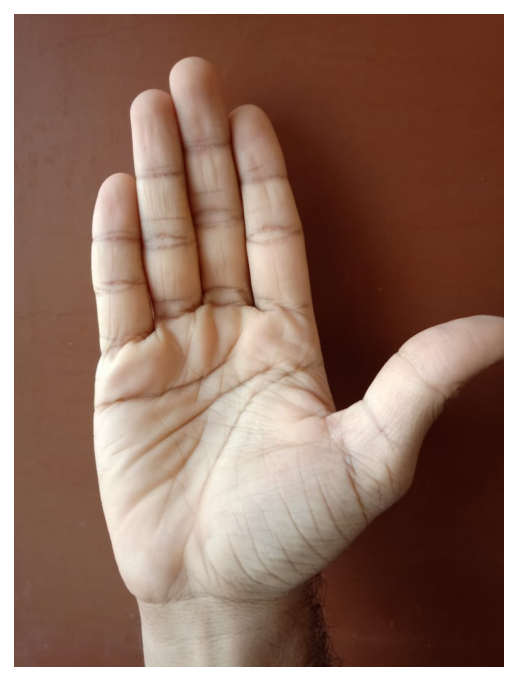

In [3]:
img_dir = '/gdrive/My Drive/Gestures_Dataset'
test_dir = '/gdrive/My Drive/Test_Gestures'
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
# Example image
x = Image.open(img_dir + '/hand/handout (10).jpeg')
np.array(x).shape
imshow(x)

In [0]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(size=224),  # Image net standards
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


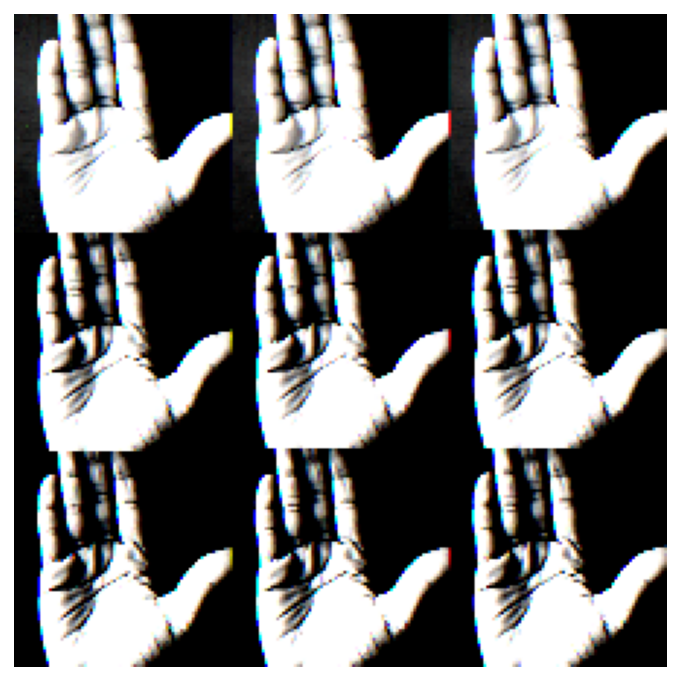

254 150 1018


In [5]:
#Loading in the dataset

train_data = datasets.ImageFolder(img_dir,transform=train_transforms)
test_data = datasets.ImageFolder(test_dir,transform=test_transforms)
# number of subprocesses to use for data loading


def imshow(image):
    """Display image"""
    image = test_transforms(image)
    print(np.shape(image))
    image = np.reshape(image, (224, 224, 3))
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
# Example image
x = Image.open(img_dir + '/hand/handout (10).jpeg')
np.array(x).shape
imshow(x)



num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2
# test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
num_test = len(test_data)
indices = list(range(num_train))
test_indices = list(range(num_test))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
# test_split = int(np.floor((valid_size+test_size) * num_train))
# valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]
valid_idx, train_idx = indices[:valid_split], indices[valid_split:]
test_idx = test_indices
print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, 
    sampler=test_sampler, num_workers=num_workers)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pretrained=True will download a pretrained network for us
model = models.resnet50(pretrained=True)

#Freezing model parameters and defining the fully connected network to be attached to the model, loss function and the optimizer.
#We there after put the model on the GPUs
for param in model.parameters():
  param.require_grad = False
model.fc = nn.Sequential(
    nn.Linear(2048, 5),
    # nn.ReLU(),
    # nn.Dropout(0.2),
    
    # nn.Linear(460,5),
    nn.LogSoftmax(dim=1)    
)
criterion = nn.NLLLoss()
#Over here we want to only update the parameters of the classifier so
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
model
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
#Training the model and saving checkpoints of best performances. That is lower validation loss and higher accuracy
epochs = 5
valid_loss_min = np.Inf
import time
for epoch in range(epochs):
    
    start = time.time()
    
    #scheduler.step()
    model.train()
    
    train_loss = 0.0
    valid_loss = 0.0
    
    i = 0
    for inputs, labels in train_loader:
        
       
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        print("iteration:",i, "/ 32")
        i = i + 1
    train_loss += loss.item()
        
       
    model.eval()
    
    with torch.no_grad():
        accuracy = 0
        for inputs, labels in valid_loader:
            
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
        valid_loss += batch_loss.item()
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            
            
    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    valid_accuracy = accuracy/len(valid_loader) 
      
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
    epoch + 1, train_loss, valid_loss, valid_accuracy))
            
    
    
    if valid_loss <= valid_loss_min:
      
      
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      model_save_name = "Gestures_NEWresnet50.pt"
      path = F"/gdrive/My Drive/Gestures_Dataset/{model_save_name}"
      torch.save(model.state_dict(), path)
      valid_loss_min = valid_loss        
      
    print(f"Time per epoch: {(time.time() - start):.3f} seconds")

iteration: 0 / 32
iteration: 1 / 32
iteration: 2 / 32
iteration: 3 / 32
iteration: 4 / 32
iteration: 5 / 32
iteration: 6 / 32
iteration: 7 / 32
iteration: 8 / 32
iteration: 9 / 32
iteration: 10 / 32
iteration: 11 / 32
iteration: 12 / 32
iteration: 13 / 32
iteration: 14 / 32
iteration: 15 / 32
iteration: 16 / 32
iteration: 17 / 32
iteration: 18 / 32
iteration: 19 / 32
iteration: 20 / 32
iteration: 21 / 32
iteration: 22 / 32
iteration: 23 / 32
iteration: 24 / 32
iteration: 25 / 32
iteration: 26 / 32


KeyboardInterrupt: ignored

In [8]:
model.load_state_dict(torch.load('/gdrive/My Drive/Gestures_Dataset/Gestures_resnet50.pt'))

<All keys matched successfully>

In [0]:
def test(model, criterion):
# monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    i = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        print("batch:", i, "/ 5")
        i = i + 1
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
test(model, criterion)

batch: 0 / 5
batch: 1 / 5
batch: 2 / 5
batch: 3 / 5
batch: 4 / 5
Test Loss: 0.199377


Test Accuracy: 94% (141/150)


In [7]:
print(test_loader.dataset.classes)

['fist', 'hand', 'rock', 'super', 'thumb']


In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image


def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

model.class_to_idx = test_loader.dataset.classes

In [0]:
def predict2(image, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    #img = Image.open(image_path)
    img = Image.fromarray(image)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

def view_classify(image, prob, classes, mapping):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img = Image.fromarray(image)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    
    ax1.set_title("Gesture")
    ax1.imshow(image)
    ax1.axis('off')

    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(mapping)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')


[0.6321236491203308, 0.2615449130535126, 0.053220830857753754, 0.0406922921538353, 0.012418314814567566]
[1, 2, 3, 0, 4]
['hand', 'rock', 'super', 'fist', 'thumb']
1
[0.9999120235443115, 5.256191798252985e-05, 2.059693360934034e-05, 9.02350166143151e-06, 5.800353392260149e-06]
[3, 2, 1, 4, 0]
['super', 'rock', 'hand', 'thumb', 'fist']
73
[0.9995641112327576, 0.00019614421762526035, 0.0001187823509098962, 0.00011787427501985803, 3.1113422664930113e-06]
[4, 1, 2, 3, 0]
['thumb', 'hand', 'rock', 'super', 'fist']
145
[0.9999858140945435, 1.1747014468710404e-05, 1.52477855408506e-06, 4.1955573237828503e-07, 4.1562546471141104e-07]
[4, 0, 1, 2, 3]
['thumb', 'fist', 'hand', 'rock', 'super']
217
[0.9969691634178162, 0.0010472715366631746, 0.0007800030871294439, 0.0006374379154294729, 0.0005661024479195476]
[0, 2, 4, 1, 3]
['fist', 'rock', 'thumb', 'hand', 'super']
289
[0.9999995231628418, 2.276515260746237e-07, 1.14111671223327e-07, 7.955224390343574e-08, 1.7950666730826015e-08]
[2, 4, 1, 3, 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


[0.4800170063972473, 0.4733836054801941, 0.01849326491355896, 0.01706700772047043, 0.0110391266644001]
[4, 0, 3, 2, 1]
['thumb', 'fist', 'super', 'rock', 'hand']
1513
[0.842944860458374, 0.08431349694728851, 0.03308458253741264, 0.029072411358356476, 0.010584559291601181]
[0, 4, 3, 2, 1]
['fist', 'thumb', 'super', 'rock', 'hand']
1585
[0.9888578653335571, 0.006196886766701937, 0.0028682928532361984, 0.001314816763624549, 0.0007621442782692611]
[3, 2, 1, 0, 4]
['super', 'rock', 'hand', 'fist', 'thumb']
1657


error: ignored

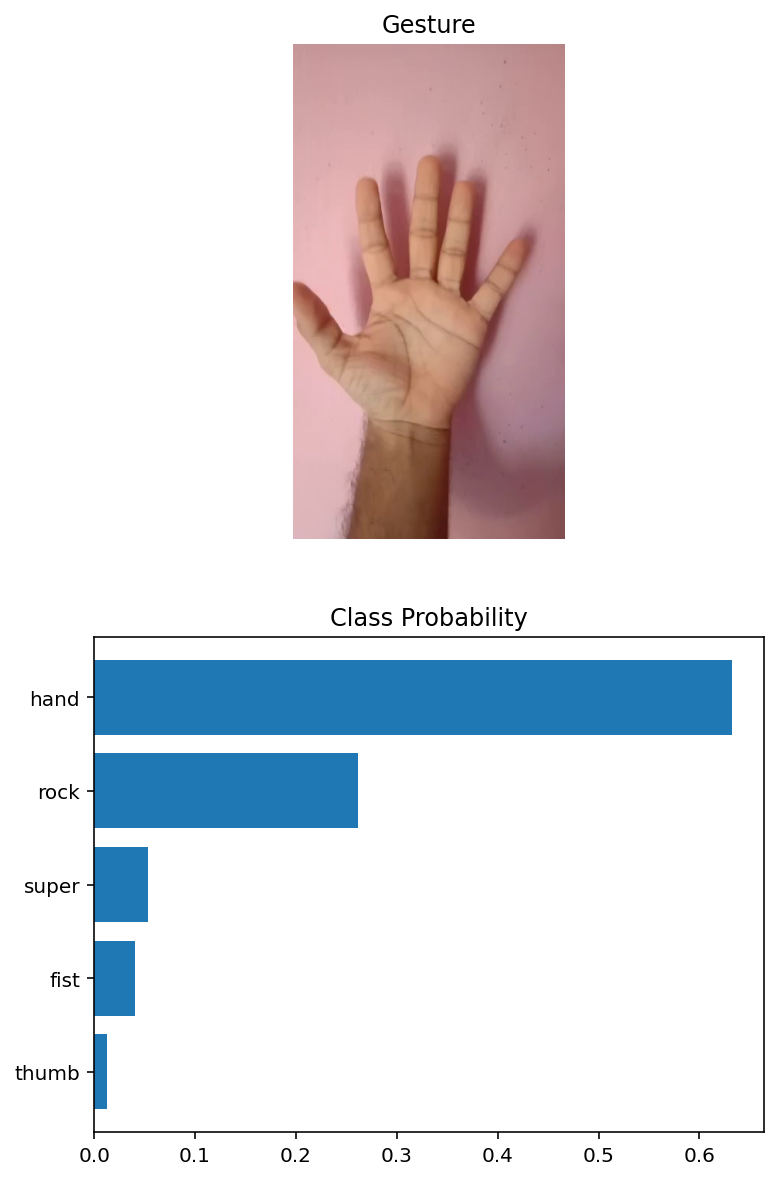

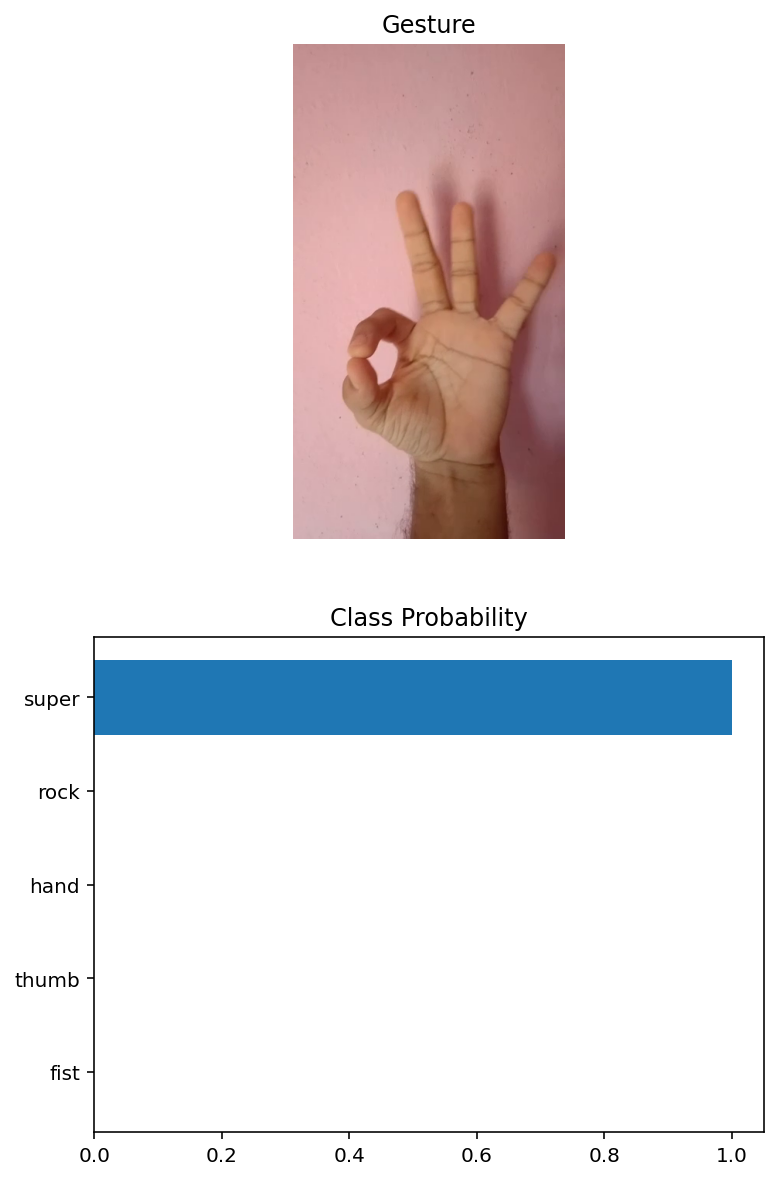

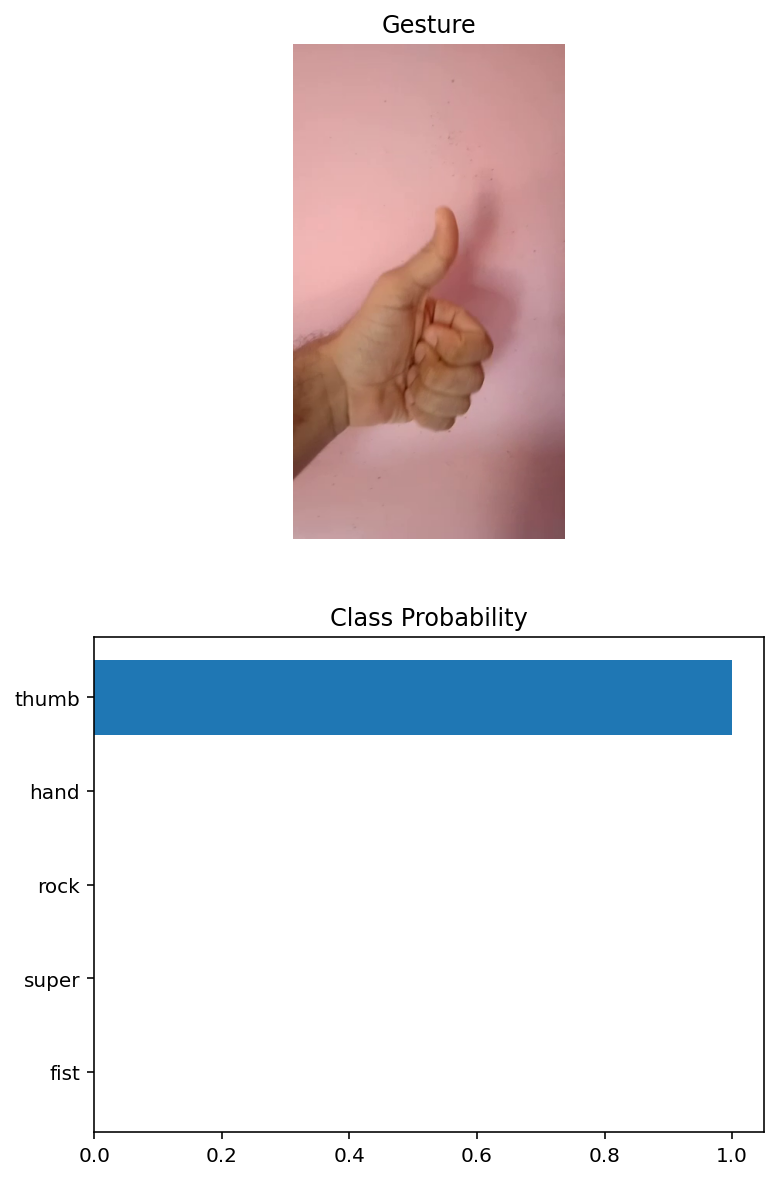

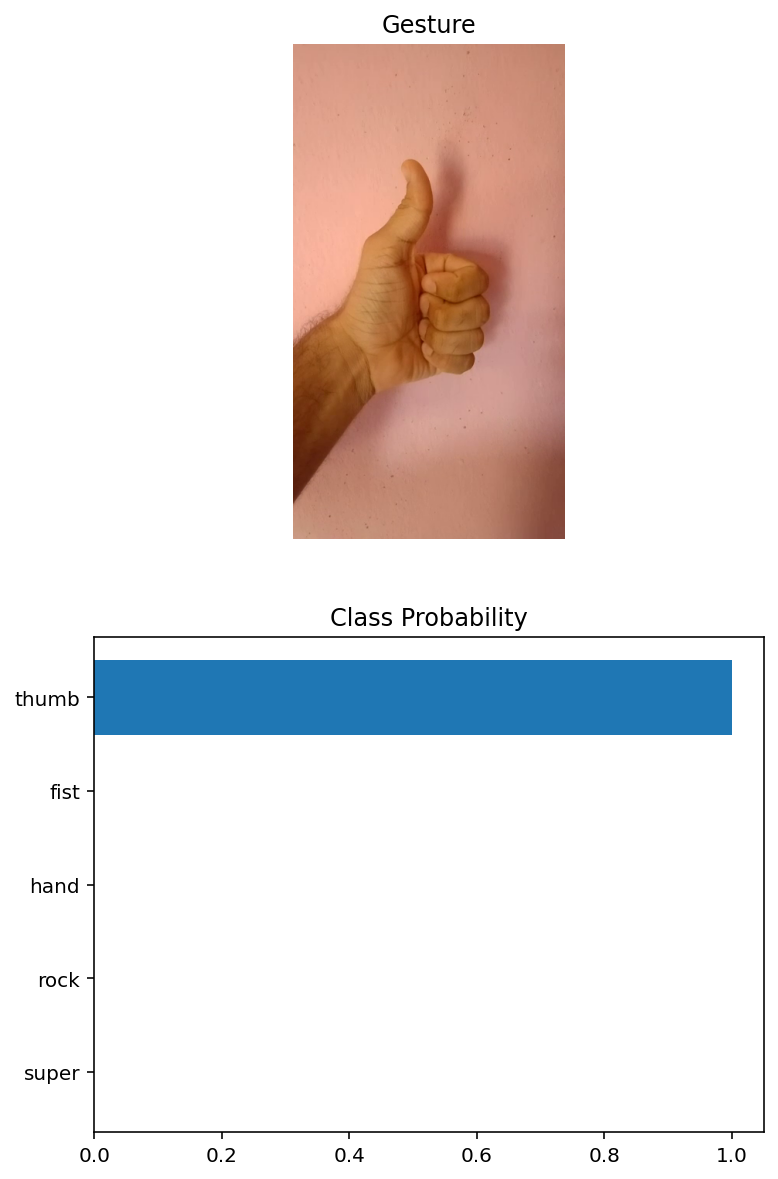

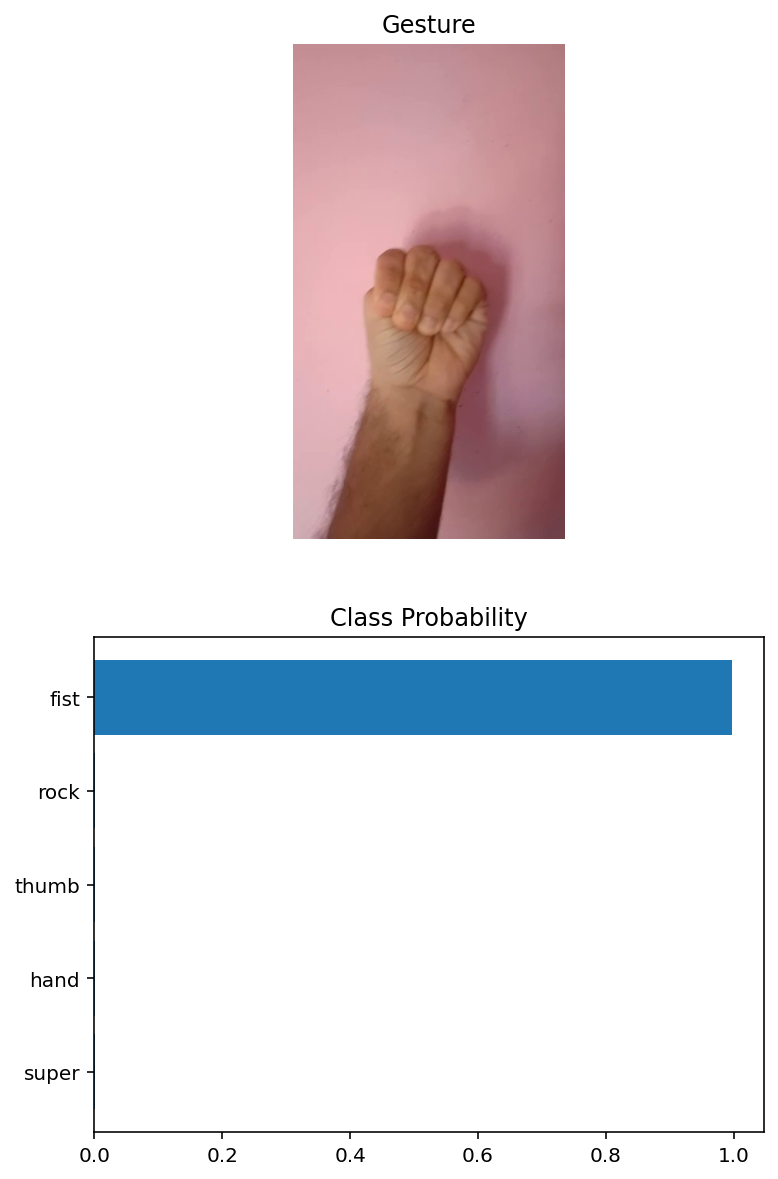

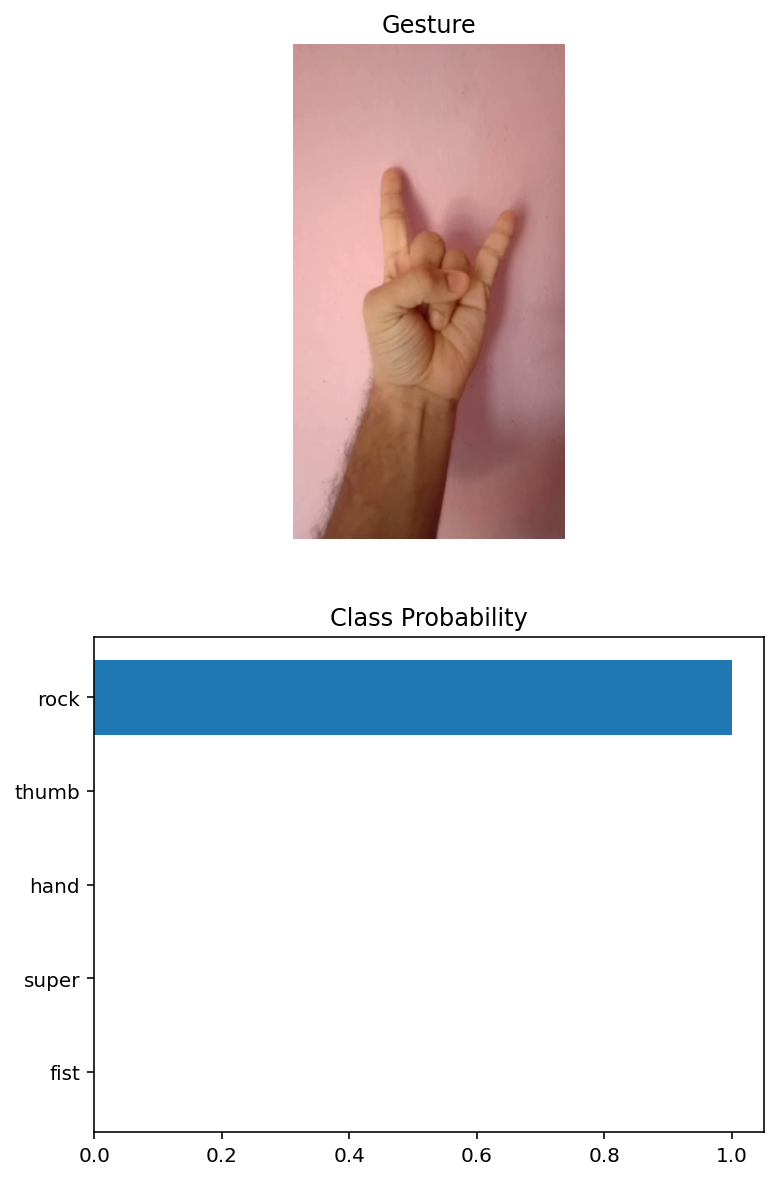

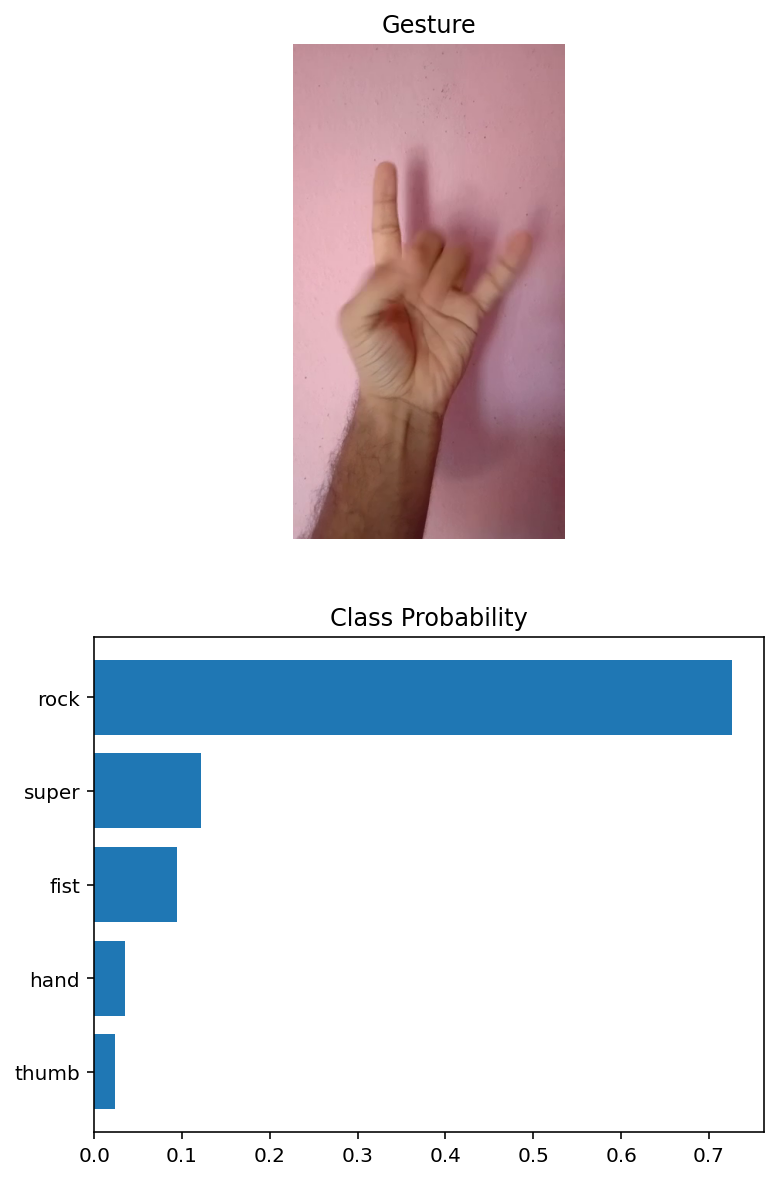

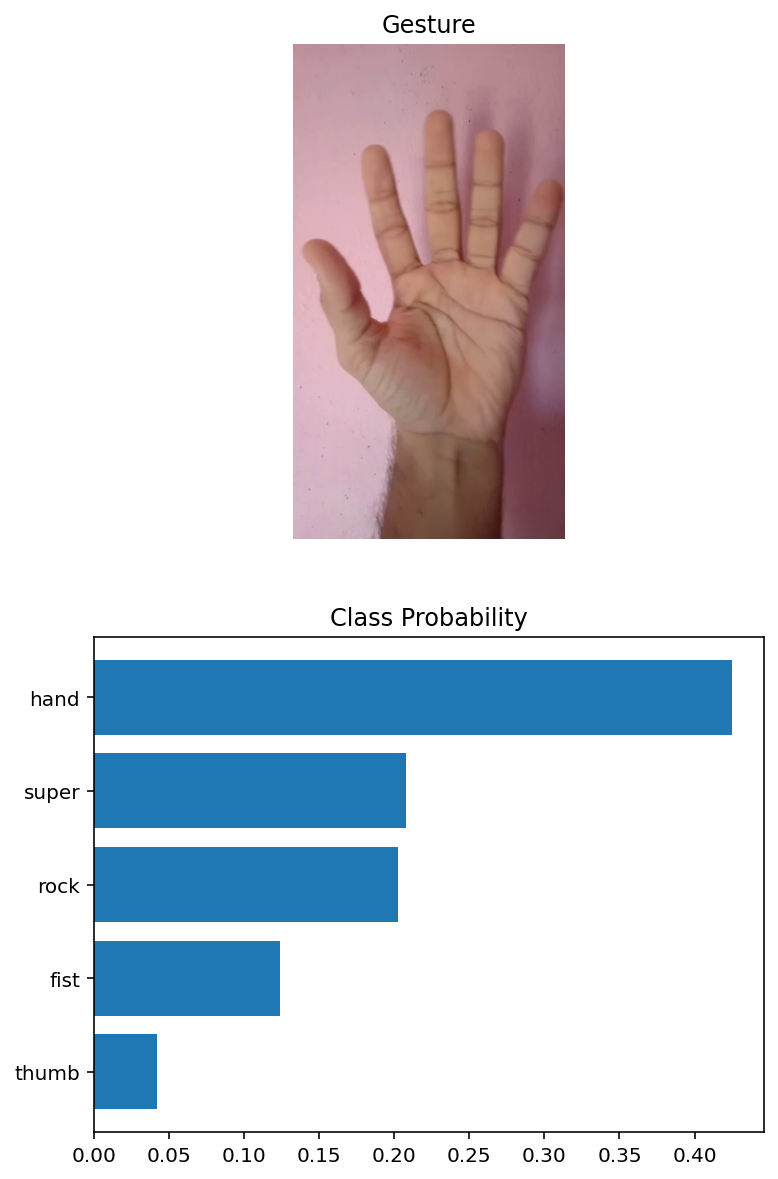

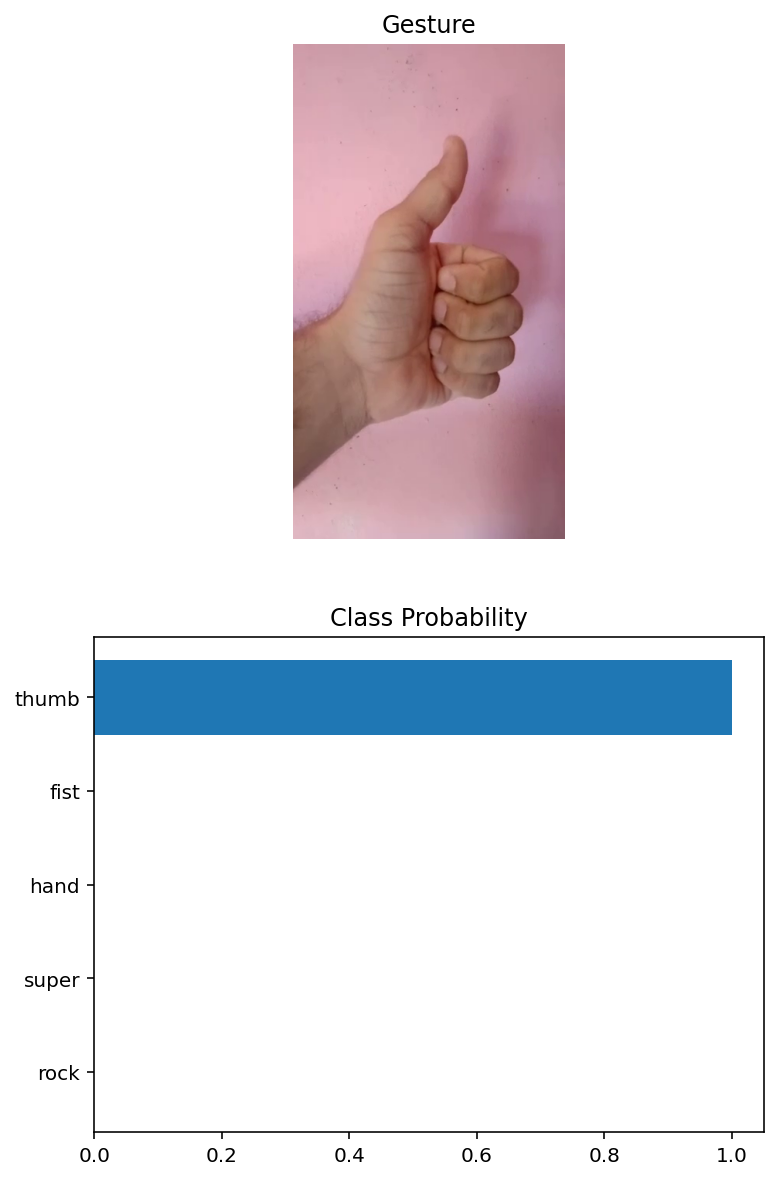

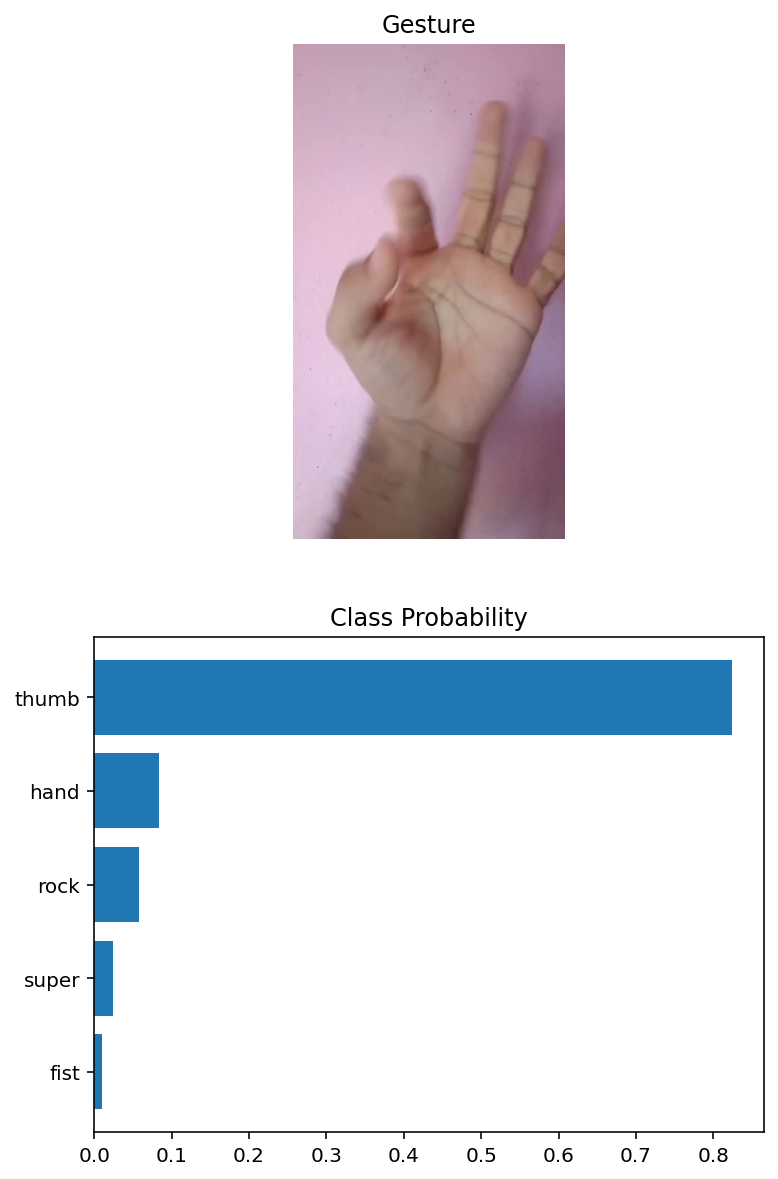

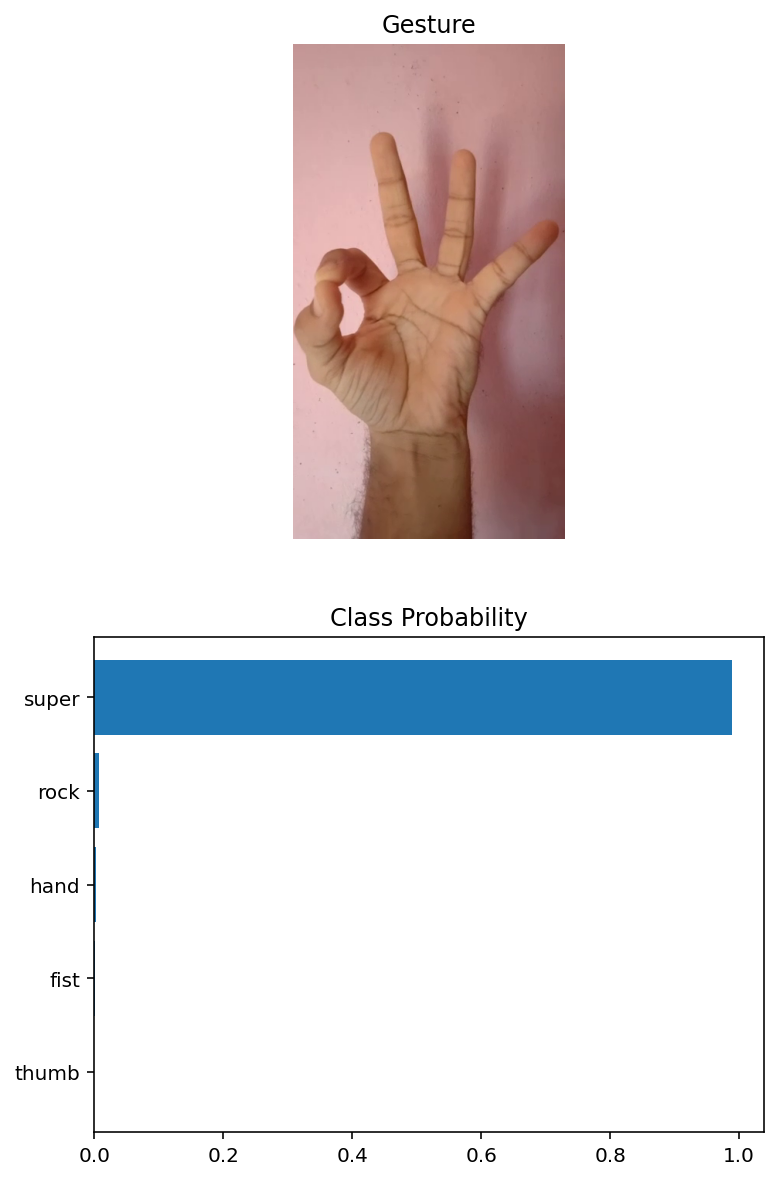

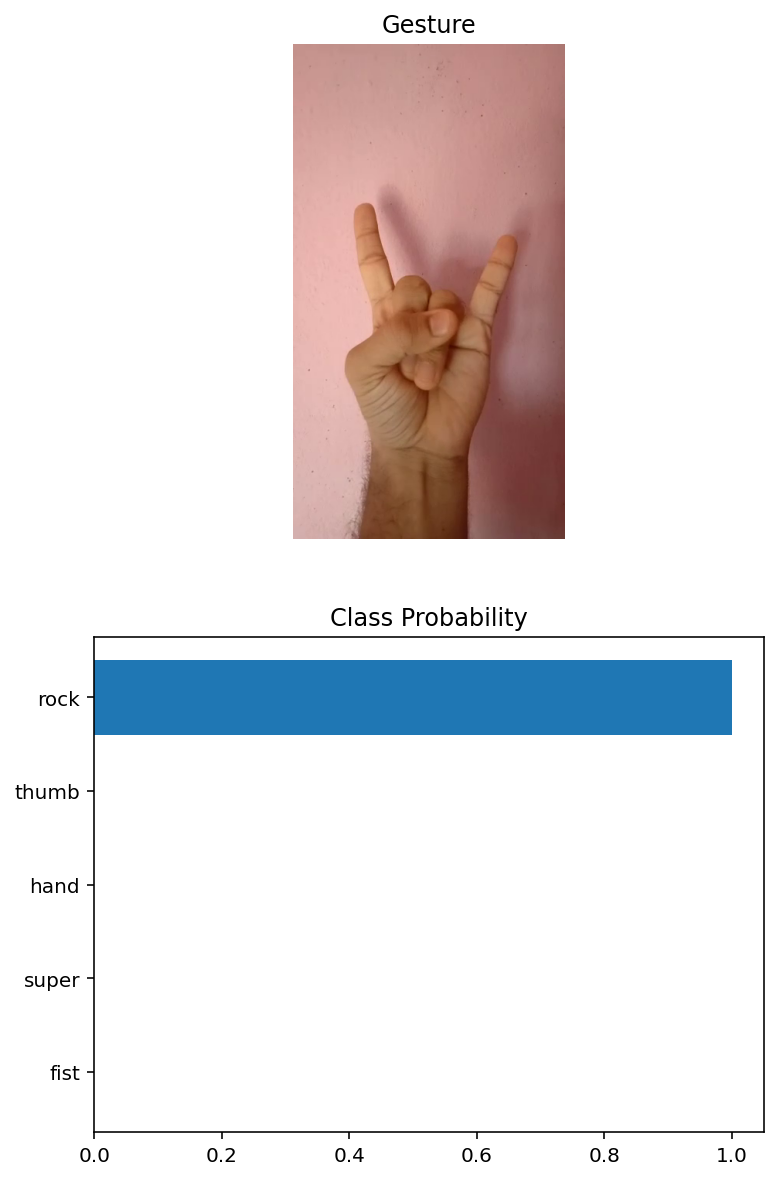

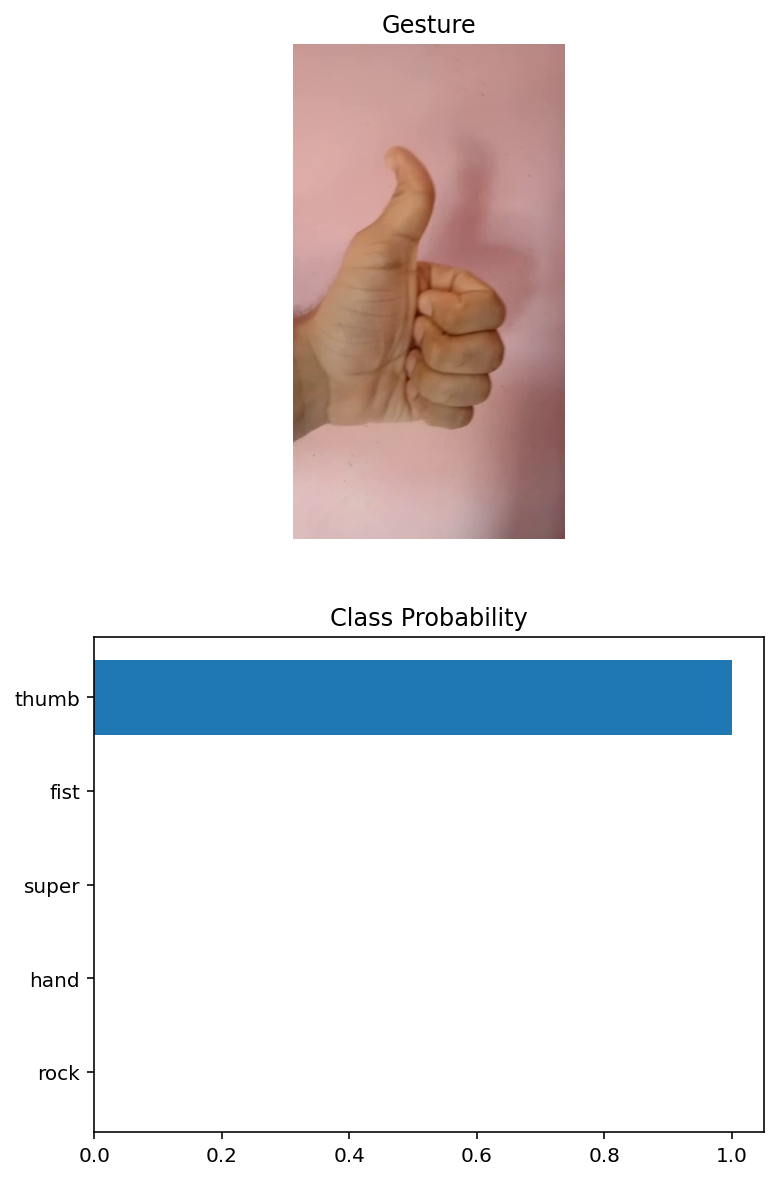

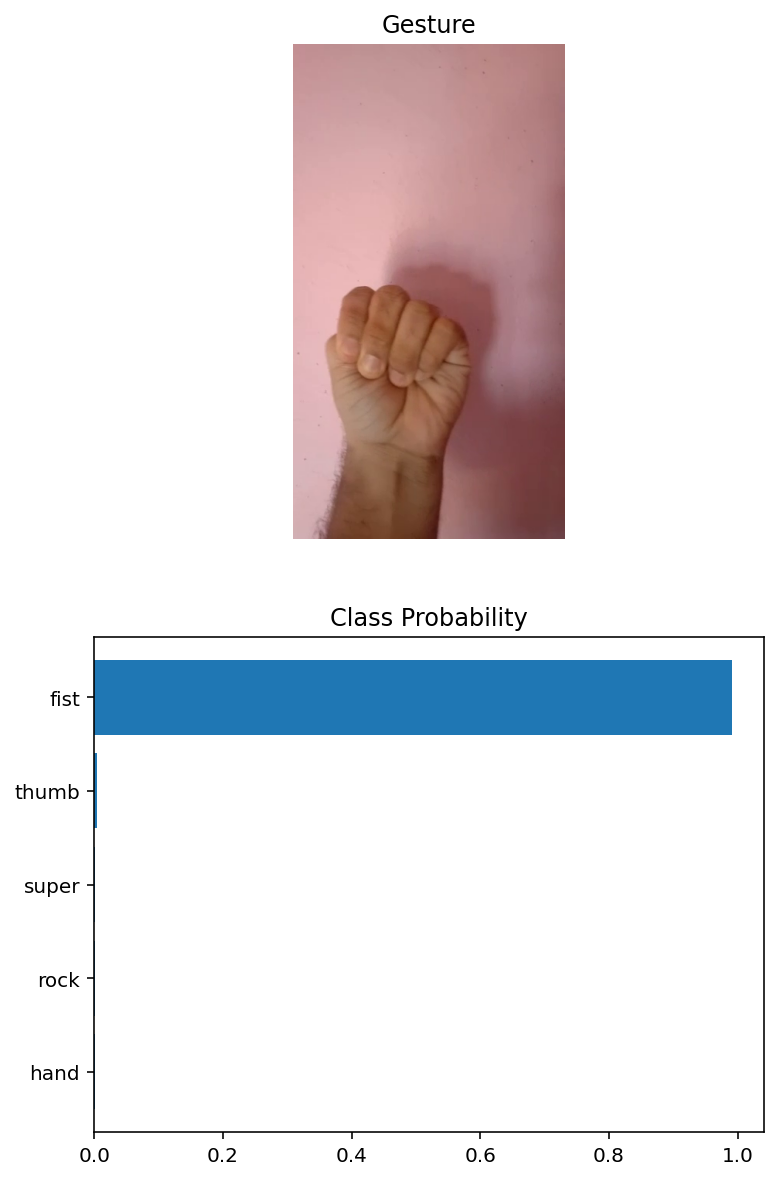

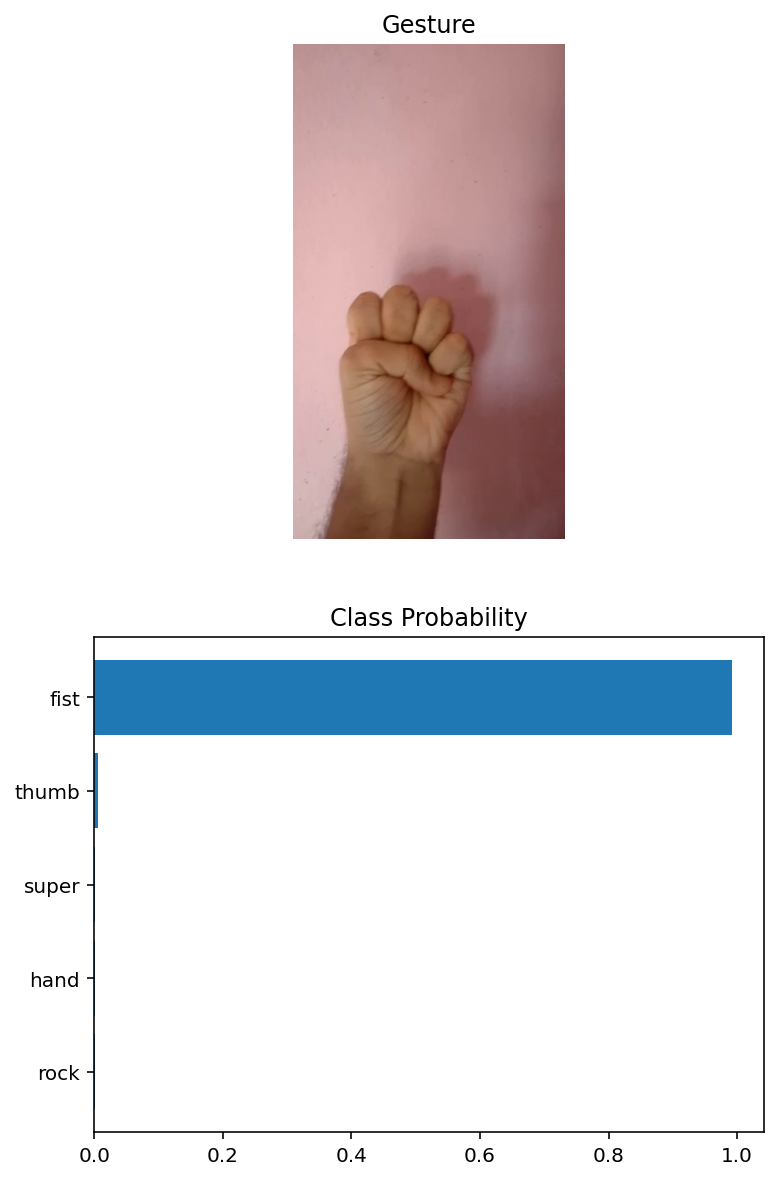

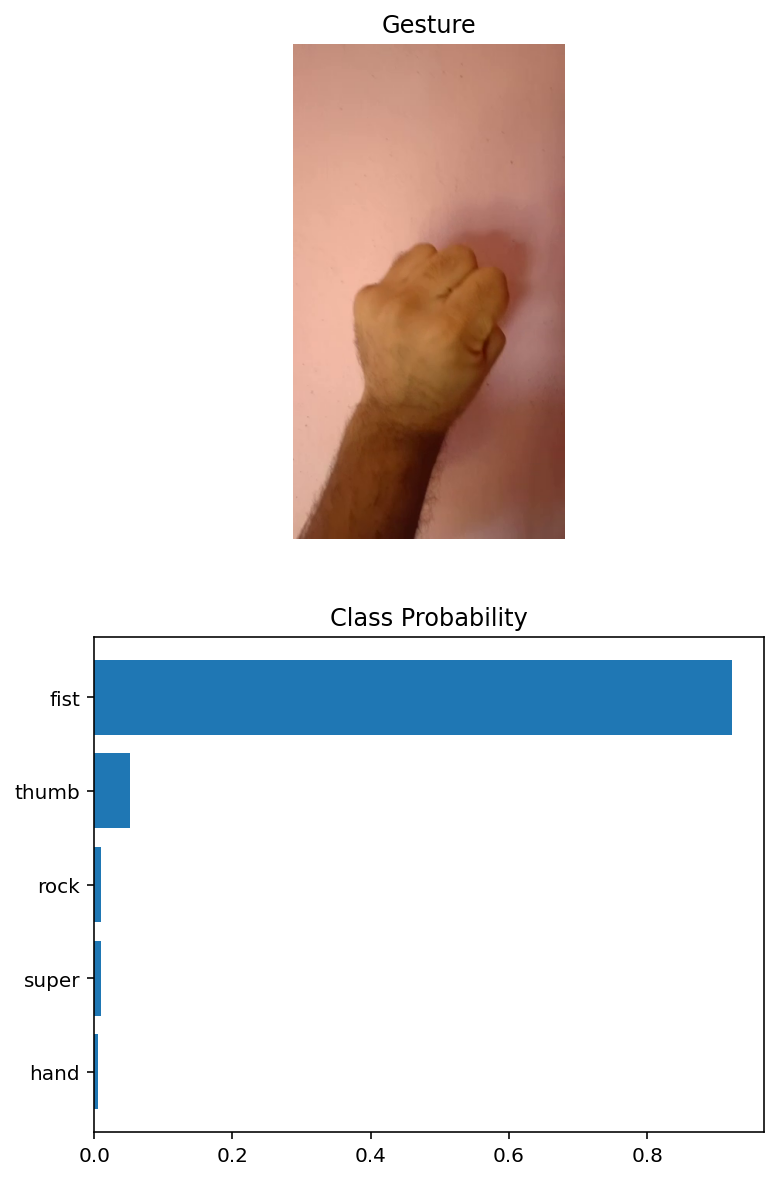

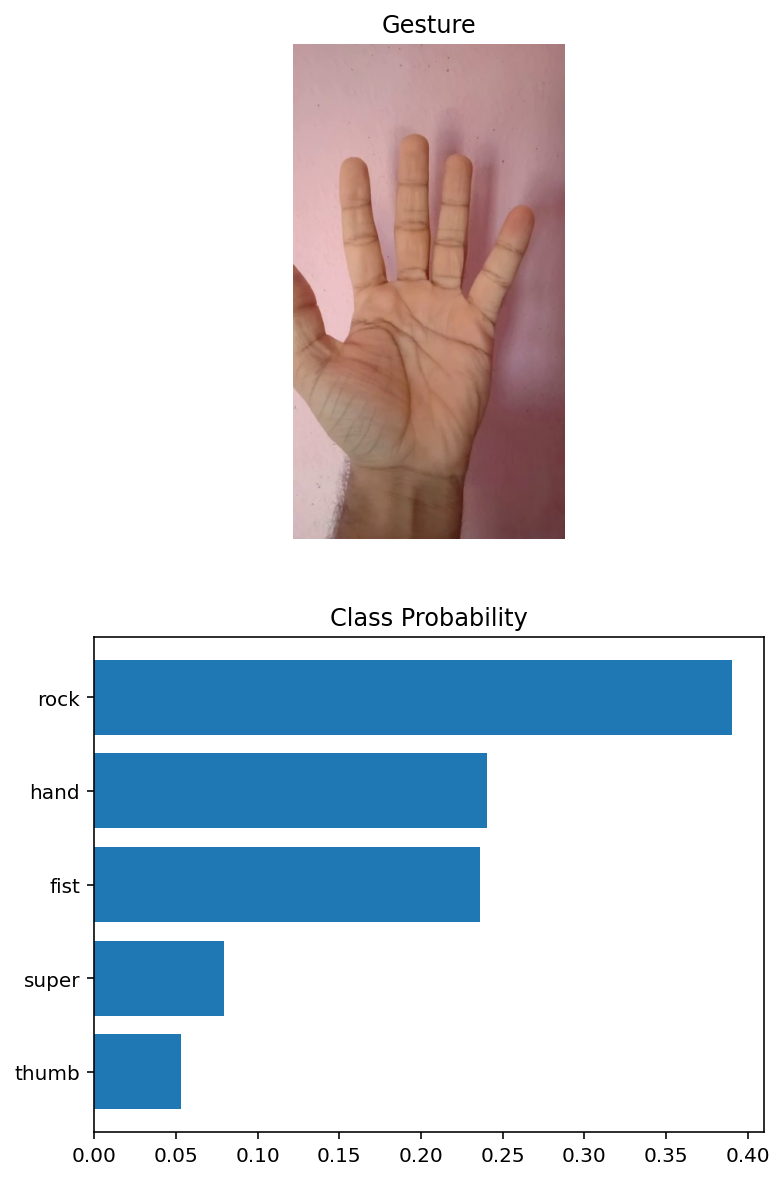

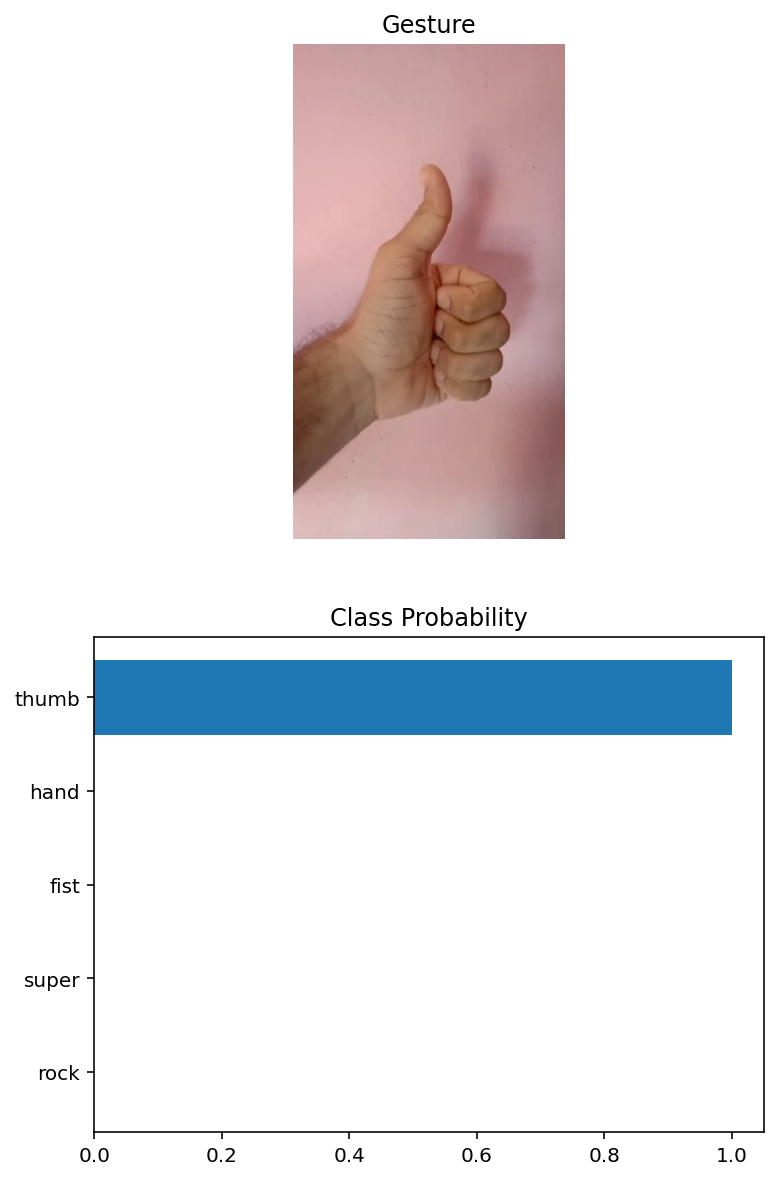

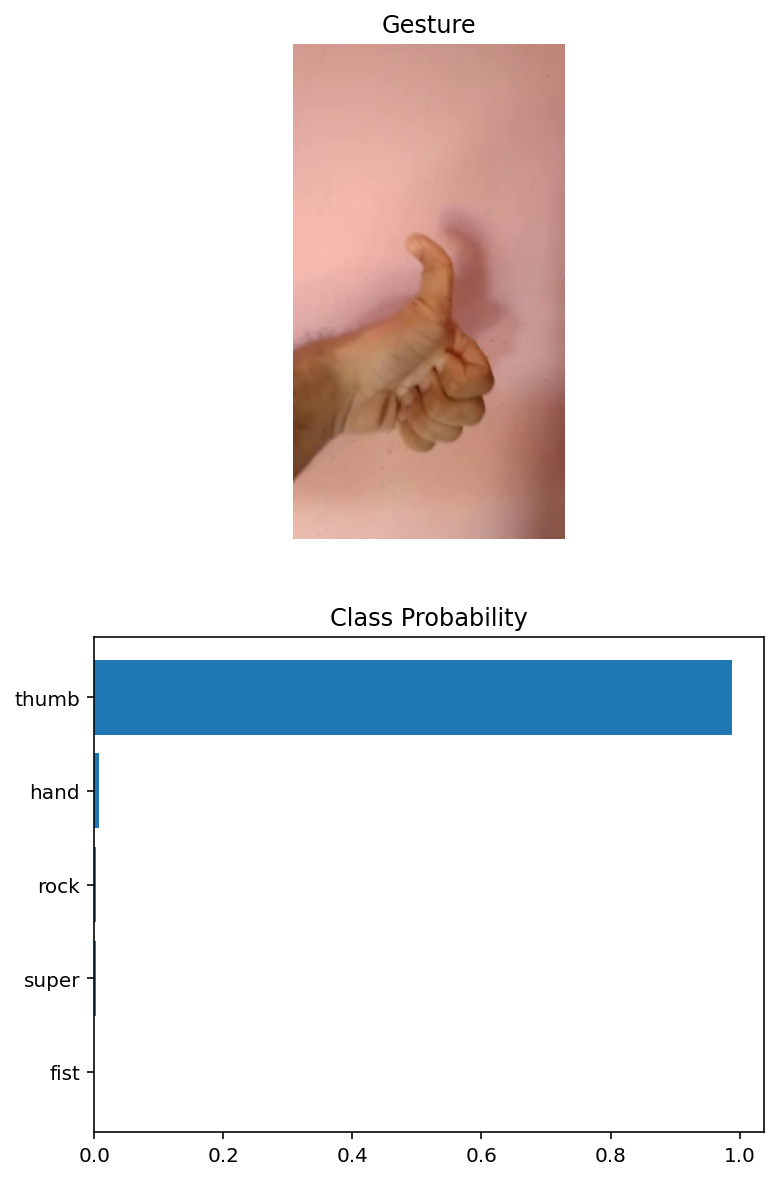

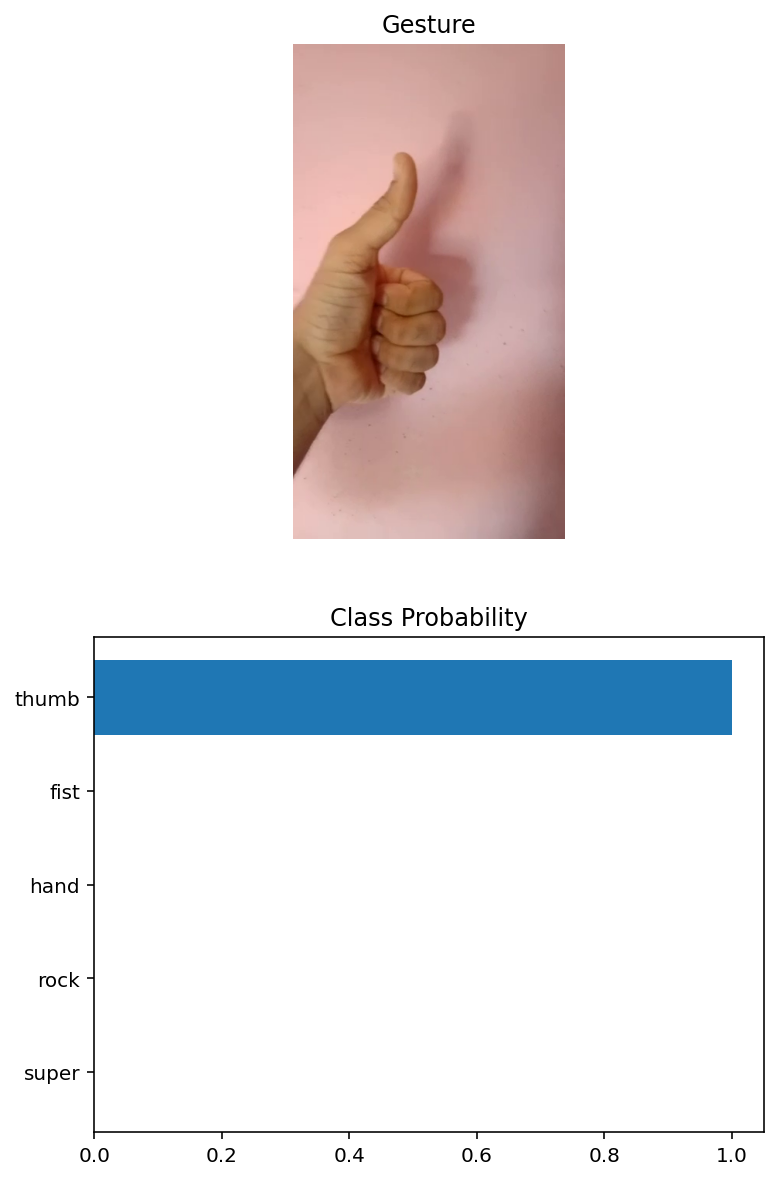

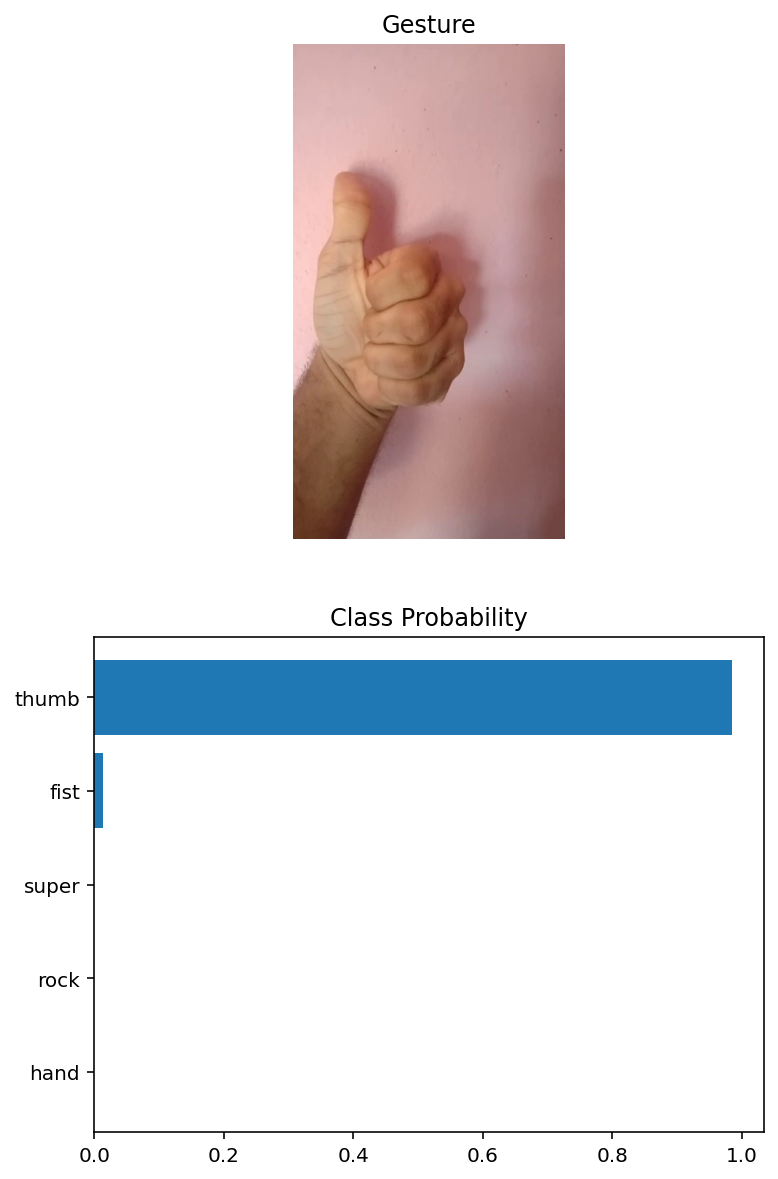

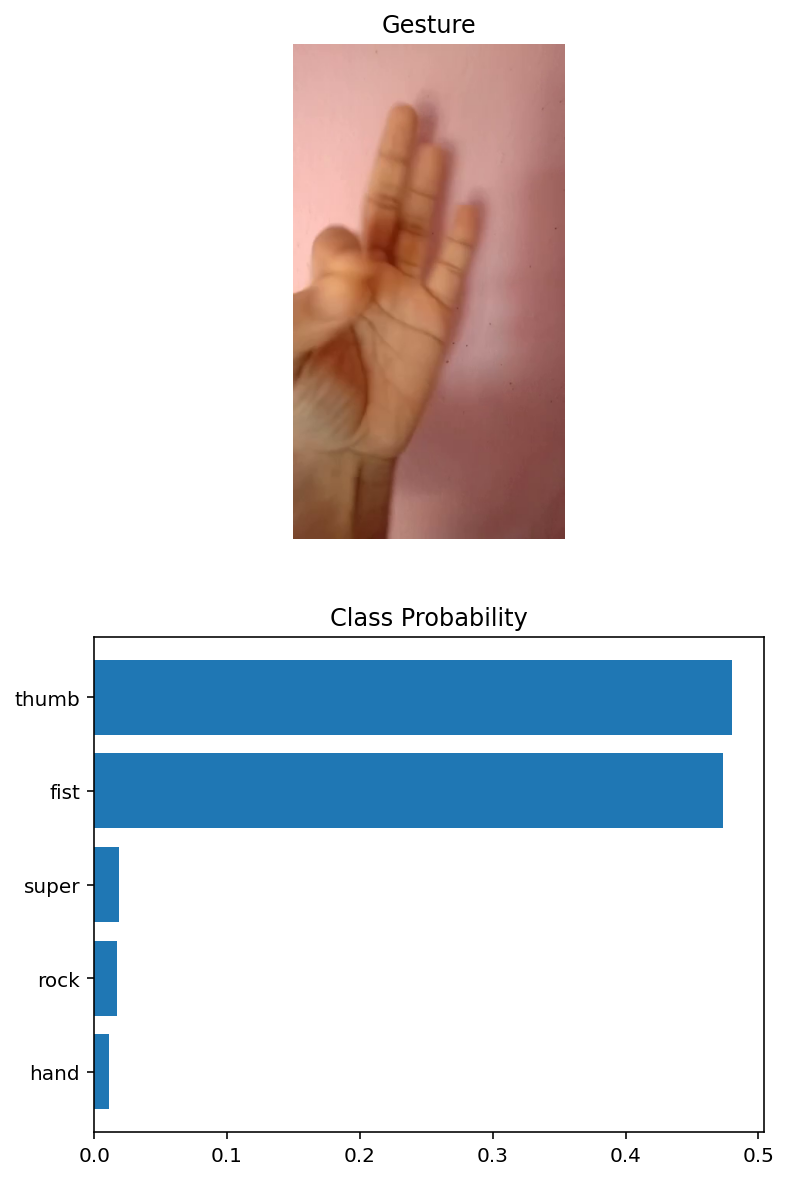

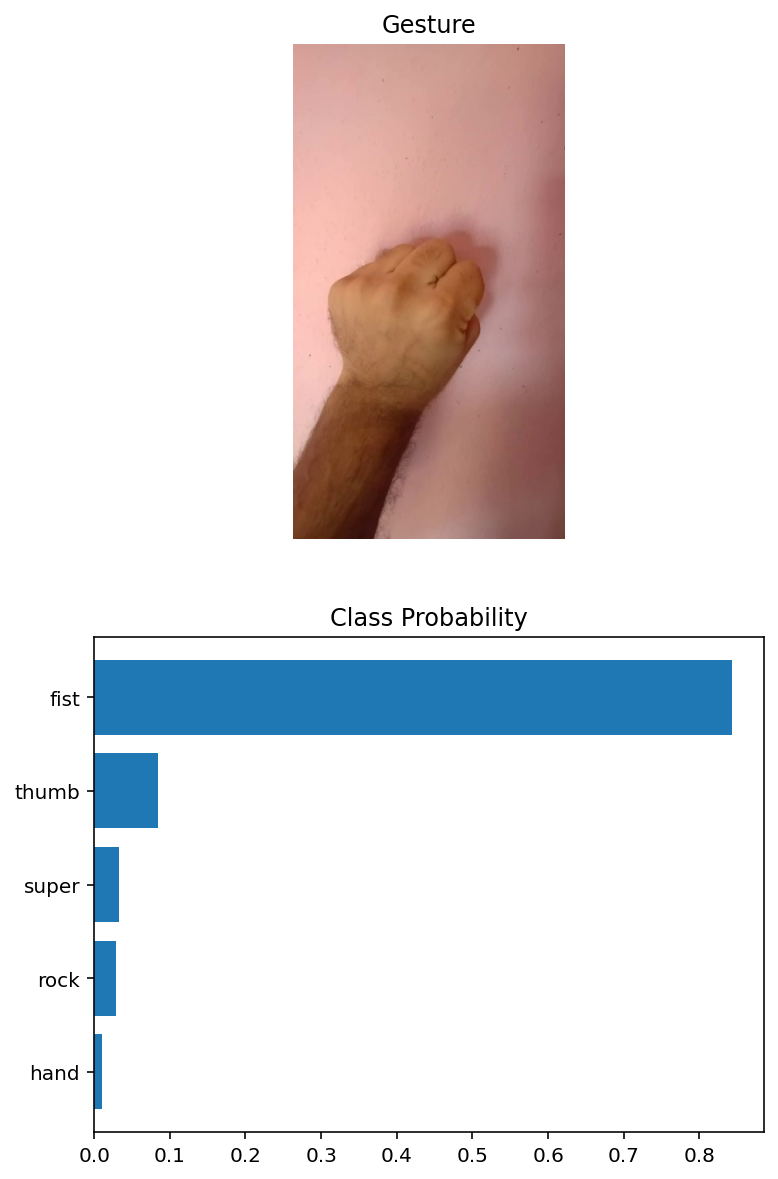

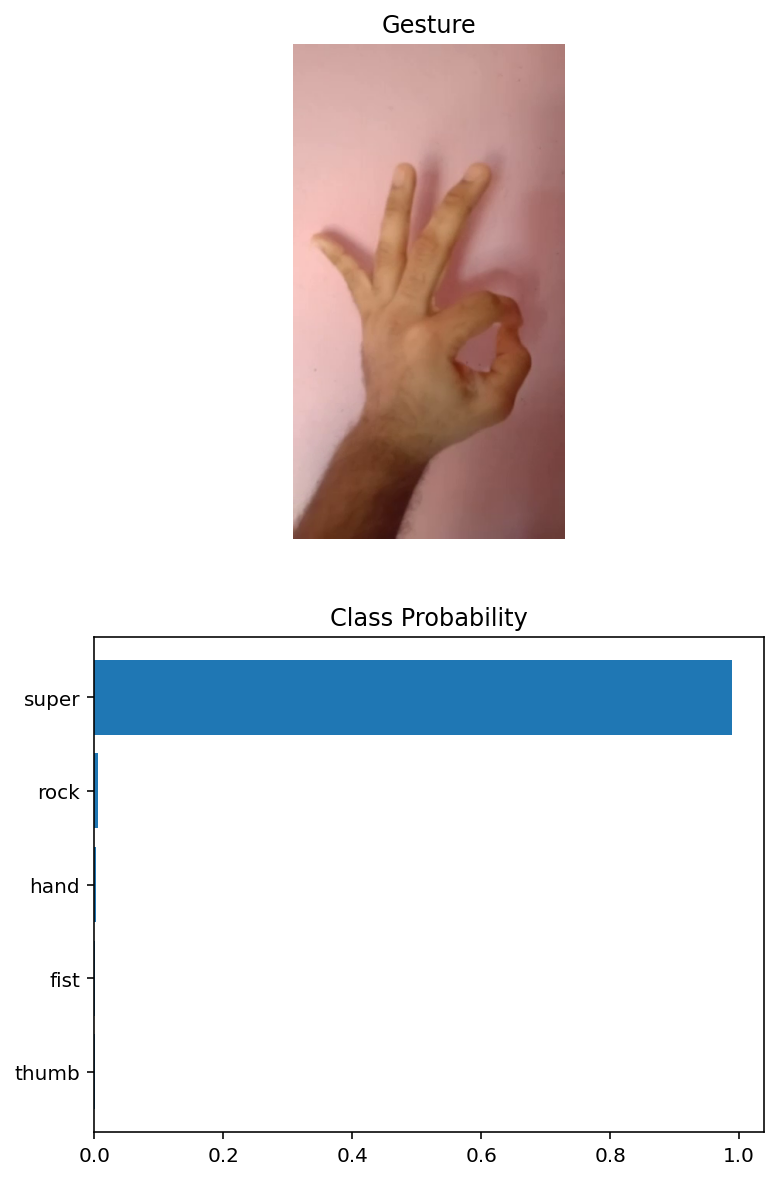

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

cap = cv2.VideoCapture("/gdrive/My Drive/3D Gestures/gestures video.mp4")
frame = 0

while(cap.isOpened()):
    ret, img = cap.read()
    while( frame % 72 == 1 ): # for Skipping similar frames
      #img = cv2.flip(img, 1)
      img = cv2.transpose(img)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      # img = Image.fromarray(img)
      # img = process_image(img)
      # #img = image_transforms(img).float()
      
      # img = np.array(img)
      # img = np.reshape(img, (224, 224, 3))

      # index = predict_frame(img)

      # print(index, np.shape(img))
      # plt.imshow(img)
      # plt.show()


      #img_path = 'flower_data/valid/18/image_04252.jpg'
      probs, classes = predict2(img, model.to(device))
      print(probs)
      print(classes)
      class_names = [test_loader.dataset.classes[e] for e in classes]
      print(class_names)

      view_classify(img, probs, classes, class_names)


      print(frame)
      frame = frame + 1

    k = cv2.waitKey(100)
    frame = frame + 1
    if k & 0xFF == ord('q'):
            break